# Spatial maps of ERA-5 climatological monthly mean variables

In [1]:
import geopy.distance
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import numpy as np
import xarray as xr
import json
import cartopy
import pandas as pd
from datetime import datetime, timedelta
import cftime
#from adjustText import adjust_text
import glob
import os

In [2]:
def get_dist_meters(lon, lat):
    """Calculate horizontal distances lat-lon grid.
    Args:
        lon: 2D array of longitudes (degrees)
        lat: 2D array of latitudes (degrees)
    Returns:
        lon_dist: 2D array of longitudes (meters)
        lat_dist: 2D array of latitudes (meters)
    """
    earth_circ = 6371 * 2 * np.pi * 1000  # earth's circumference in meters
    lat_met = earth_circ / 360  # get the number of meters in a degree latitude (ignoring "bulge")
    lat_dist = np.gradient(lat,axis=0) * lat_met
    lon_dist = np.gradient(lon,axis=1) * np.cos(np.deg2rad(lat)) * lat_met
    return lon_dist, lat_dist

In [3]:
def calc_div(u, v, lon, lat):
    """Calculate horizontal divergence of a vector field (u,v) on a time-lat-lon grid.
    Args:
        u: 3D array of zonal wind component (m/s)
        v: 3D array of meridional wind component (m/s)
        lon: 2D array of longitudes (degrees)
        lat: 2D array of latitudes (degrees)
    Returns:
        div: 3D array of horizontal divergence (1/s)
    """
    dx, dy = get_dist_meters(lon, lat) # get distance array
    du_dx = np.gradient(u, axis=2) / dx
    dv_dy = np.gradient(v, axis=1) / dy
    div = du_dx + dv_dy # horizontal divergence
    return div

In [4]:
lonMin, lonMax = -70.1, 20.1
latMin, latMax = -12.1, 22.1

In [5]:
era5 = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_monthly_uv_1000_850_600.nc')
era5

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 360, pressure_level: 3, latitude: 241,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * pressure_level  (pressure_level) float64 24B 1e+03 850.0 600.0
  * latitude        (latitude) float64 2kB 30.0 29.75 29.5 ... -29.75 -30.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 6kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 1GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-25T15:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
era5_vipile_tcwv_sst = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_monthly_vipile_tcwv_sst.nc')
era5_vimd = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_monthly_vimd.nc')
era5_tqzd = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_monthly_tqzd_1000_950_900_850.nc')
era5_tqzd

<xarray.Dataset> Size: 8GB
Dimensions:         (valid_time: 360, pressure_level: 4, latitude: 241,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * pressure_level  (pressure_level) float64 32B 1e+03 950.0 900.0 850.0
  * latitude        (latitude) float64 2kB 30.0 29.75 29.5 ... -29.75 -30.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 6kB ...
Data variables:
    d               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    z               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    q               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    t               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-01T19:52 GRIB to CDM+CF via cfgrib-0.9.1...

Calculate shear

In [66]:
# calculate wind shear

# 1000 to 600 hPa [approx equivalent of 0-6 km]
era5_shear06 = np.sqrt( (era5.u.sel(pressure_level=600) - era5.u.sel(pressure_level=1000))**2 + (era5.v.sel(pressure_level=600) - era5.v.sel(pressure_level=1000))**2 )

# 1000 to 850 hPa [approx equivalent of 0-2 km]
era5_shear02 = np.sqrt( (era5.u.sel(pressure_level=850) - era5.u.sel(pressure_level=1000))**2 + (era5.v.sel(pressure_level=850) - era5.v.sel(pressure_level=1000))**2 )

Calculate low-level convergence

In [49]:
# Make a meshed grid
lon2d, lat2d = np.meshgrid(era5.longitude, era5.latitude)

# calculate divergence 
era5_div1000 = calc_div(era5.u.sel(pressure_level=1000), era5.v.sel(pressure_level=1000), lon2d, lat2d)

In [ ]:
# convert to xarray
era5_div1000 = xr.DataArray(era5_div1000, coords=era5.u.sel(pressure_level=1000).coords, dims=era5.u.sel(pressure_level=1000).dims)

In [10]:
# or use directly from era5
era5_div1000 = era5_tqzd.d.sel(pressure_level=1000)

Take climatological mean for each month

In [ ]:
# Climo mean for each month (u,v)
era5_Jan = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==1]).mean(dim='valid_time')
era5_Feb = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==2]).mean(dim='valid_time')
era5_Mar = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==3]).mean(dim='valid_time')
era5_Apr = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==4]).mean(dim='valid_time')
era5_May = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==5]).mean(dim='valid_time')
era5_Jun = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==6]).mean(dim='valid_time')
era5_Jul = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==7]).mean(dim='valid_time')
era5_Aug = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==8]).mean(dim='valid_time')
era5_Sep = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==9]).mean(dim='valid_time')
era5_Oct = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==10]).mean(dim='valid_time')
era5_Nov = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==11]).mean(dim='valid_time')
era5_Dec = era5.sel(valid_time = era5.valid_time[era5.valid_time.dt.month==12]).mean(dim='valid_time')

In [12]:
era5_vipile_tcwv_sst_Jan = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==1]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Feb = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==2]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Mar = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==3]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Apr = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==4]).mean(dim='valid_time')
era5_vipile_tcwv_sst_May = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==5]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Jun = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==6]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Jul = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==7]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Aug = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==8]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Sep = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==9]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Oct = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==10]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Nov = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==11]).mean(dim='valid_time')
era5_vipile_tcwv_sst_Dec = era5_vipile_tcwv_sst.sel(valid_time = era5_vipile_tcwv_sst.valid_time[era5_vipile_tcwv_sst.valid_time.dt.month==12]).mean(dim='valid_time')   

In [13]:
era5_vimd_Jan = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==1]).mean(dim='valid_time')
era5_vimd_Feb = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==2]).mean(dim='valid_time')
era5_vimd_Mar = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==3]).mean(dim='valid_time')
era5_vimd_Apr = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==4]).mean(dim='valid_time')
era5_vimd_May = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==5]).mean(dim='valid_time')
era5_vimd_Jun = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==6]).mean(dim='valid_time')
era5_vimd_Jul = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==7]).mean(dim='valid_time')
era5_vimd_Aug = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==8]).mean(dim='valid_time')
era5_vimd_Sep = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==9]).mean(dim='valid_time')
era5_vimd_Oct = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==10]).mean(dim='valid_time')
era5_vimd_Nov = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==11]).mean(dim='valid_time')
era5_vimd_Dec = era5_vimd.sel(valid_time = era5_vimd.valid_time[era5_vimd.valid_time.dt.month==12]).mean(dim='valid_time')

In [14]:
era5_tqzd_Jan = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==1]).mean(dim='valid_time')
era5_tqzd_Feb = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==2]).mean(dim='valid_time')
era5_tqzd_Mar = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==3]).mean(dim='valid_time')
era5_tqzd_Apr = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==4]).mean(dim='valid_time')
era5_tqzd_May = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==5]).mean(dim='valid_time')
era5_tqzd_Jun = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==6]).mean(dim='valid_time')
era5_tqzd_Jul = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==7]).mean(dim='valid_time')
era5_tqzd_Aug = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==8]).mean(dim='valid_time')
era5_tqzd_Sep = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==9]).mean(dim='valid_time')
era5_tqzd_Oct = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==10]).mean(dim='valid_time')
era5_tqzd_Nov = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==11]).mean(dim='valid_time')
era5_tqzd_Dec = era5_tqzd.sel(valid_time = era5_tqzd.valid_time[era5_tqzd.valid_time.dt.month==12]).mean(dim='valid_time')

In [72]:
# Climo mean of shear
era5_shear06_Jan = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==1]).mean(dim='valid_time')
era5_shear06_Feb = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==2]).mean(dim='valid_time')
era5_shear06_Mar = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==3]).mean(dim='valid_time')
era5_shear06_Apr = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==4]).mean(dim='valid_time')
era5_shear06_May = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==5]).mean(dim='valid_time')
era5_shear06_Jun = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==6]).mean(dim='valid_time')
era5_shear06_Jul = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==7]).mean(dim='valid_time')
era5_shear06_Aug = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==8]).mean(dim='valid_time')
era5_shear06_Sep = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==9]).mean(dim='valid_time')
era5_shear06_Oct = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==10]).mean(dim='valid_time')
era5_shear06_Nov = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==11]).mean(dim='valid_time')
era5_shear06_Dec = era5_shear06.sel(valid_time = era5_shear06.valid_time[era5_shear06.valid_time.dt.month==12]).mean(dim='valid_time')

era5_shear02_Jan = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==1]).mean(dim='valid_time')
era5_shear02_Feb = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==2]).mean(dim='valid_time')
era5_shear02_Mar = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==3]).mean(dim='valid_time')
era5_shear02_Apr = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==4]).mean(dim='valid_time')
era5_shear02_May = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==5]).mean(dim='valid_time')
era5_shear02_Jun = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==6]).mean(dim='valid_time')
era5_shear02_Jul = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==7]).mean(dim='valid_time')
era5_shear02_Aug = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==8]).mean(dim='valid_time')
era5_shear02_Sep = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==9]).mean(dim='valid_time')
era5_shear02_Oct = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==10]).mean(dim='valid_time')
era5_shear02_Nov = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==11]).mean(dim='valid_time')
era5_shear02_Dec = era5_shear02.sel(valid_time = era5_shear02.valid_time[era5_shear02.valid_time.dt.month==12]).mean(dim='valid_time')

In [15]:
# Climo mean of divergence
era5_div1000_Jan = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==1]).mean(dim='valid_time')
era5_div1000_Feb = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==2]).mean(dim='valid_time')
era5_div1000_Mar = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==3]).mean(dim='valid_time')
era5_div1000_Apr = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==4]).mean(dim='valid_time')
era5_div1000_May = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==5]).mean(dim='valid_time')
era5_div1000_Jun = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==6]).mean(dim='valid_time')
era5_div1000_Jul = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==7]).mean(dim='valid_time')
era5_div1000_Aug = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==8]).mean(dim='valid_time')
era5_div1000_Sep = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==9]).mean(dim='valid_time')
era5_div1000_Oct = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==10]).mean(dim='valid_time')
era5_div1000_Nov = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==11]).mean(dim='valid_time')
era5_div1000_Dec = era5_div1000.sel(valid_time = era5_div1000.valid_time[era5_div1000.valid_time.dt.month==12]).mean(dim='valid_time')

In [7]:
#Concatenate into one dataset
era5_monthly_climo = xr.concat([era5_Jan, era5_Feb, era5_Mar, era5_Apr, era5_May, era5_Jun, 
                               era5_Jul, era5_Aug, era5_Sep, era5_Oct, era5_Nov, era5_Dec], 
                              dim='month')
era5_monthly_climo['month'] = np.arange(1,13)
era5_monthly_climo

<xarray.Dataset> Size: 100MB
Dimensions:         (month: 12, pressure_level: 3, latitude: 241,
                     longitude: 1440)
Coordinates:
    number          int64 8B 0
  * pressure_level  (pressure_level) float64 24B 1e+03 850.0 600.0
  * latitude        (latitude) float64 2kB 30.0 29.75 29.5 ... -29.75 -30.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
  * month           (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u               (month, pressure_level, latitude, longitude) float32 50MB ...
    v               (month, pressure_level, latitude, longitude) float32 50MB ...

In [17]:
era5_vipile_tcwv_sst_climo = xr.concat([era5_vipile_tcwv_sst_Jan, era5_vipile_tcwv_sst_Feb, era5_vipile_tcwv_sst_Mar, era5_vipile_tcwv_sst_Apr,
                                        era5_vipile_tcwv_sst_May, era5_vipile_tcwv_sst_Jun, era5_vipile_tcwv_sst_Jul, era5_vipile_tcwv_sst_Aug,
                                        era5_vipile_tcwv_sst_Sep, era5_vipile_tcwv_sst_Oct, era5_vipile_tcwv_sst_Nov, era5_vipile_tcwv_sst_Dec],
                                       dim='month')
era5_vipile_tcwv_sst_climo['month'] = np.arange(1,13)

In [18]:
era5_vimd_climo = xr.concat([era5_vimd_Jan, era5_vimd_Feb, era5_vimd_Mar, era5_vimd_Apr, era5_vimd_May, era5_vimd_Jun,  
                               era5_vimd_Jul, era5_vimd_Aug, era5_vimd_Sep, era5_vimd_Oct, era5_vimd_Nov, era5_vimd_Dec], 
                              dim='month')
era5_vimd_climo['month'] = np.arange(1,13)

In [19]:
era5_tqzd_climo = xr.concat([era5_tqzd_Jan, era5_tqzd_Feb, era5_tqzd_Mar, era5_tqzd_Apr, era5_tqzd_May, era5_tqzd_Jun,  
                               era5_tqzd_Jul, era5_tqzd_Aug, era5_tqzd_Sep, era5_tqzd_Oct, era5_tqzd_Nov, era5_tqzd_Dec], 
                              dim='month')
era5_tqzd_climo['month'] = np.arange(1,13)

In [73]:
era5_shear06_climo = xr.concat([era5_shear06_Jan, era5_shear06_Feb, era5_shear06_Mar, era5_shear06_Apr, era5_shear06_May, era5_shear06_Jun, 
                               era5_shear06_Jul, era5_shear06_Aug, era5_shear06_Sep, era5_shear06_Oct, era5_shear06_Nov, era5_shear06_Dec], 
                              dim='month')
era5_shear06_climo['month'] = np.arange(1,13)

era5_shear02_climo = xr.concat([era5_shear02_Jan, era5_shear02_Feb, era5_shear02_Mar, era5_shear02_Apr, era5_shear02_May, era5_shear02_Jun, 
                               era5_shear02_Jul, era5_shear02_Aug, era5_shear02_Sep, era5_shear02_Oct, era5_shear02_Nov, era5_shear02_Dec], 
                              dim='month')
era5_shear02_climo['month'] = np.arange(1,13)

In [20]:
era5_div1000_climo = xr.concat([era5_div1000_Jan, era5_div1000_Feb, era5_div1000_Mar, era5_div1000_Apr, era5_div1000_May, era5_div1000_Jun, 
                               era5_div1000_Jul, era5_div1000_Aug, era5_div1000_Sep, era5_div1000_Oct, era5_div1000_Nov, era5_div1000_Dec], 
                              dim='month')
era5_div1000_climo['month'] = np.arange(1,13)

Plot shear

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


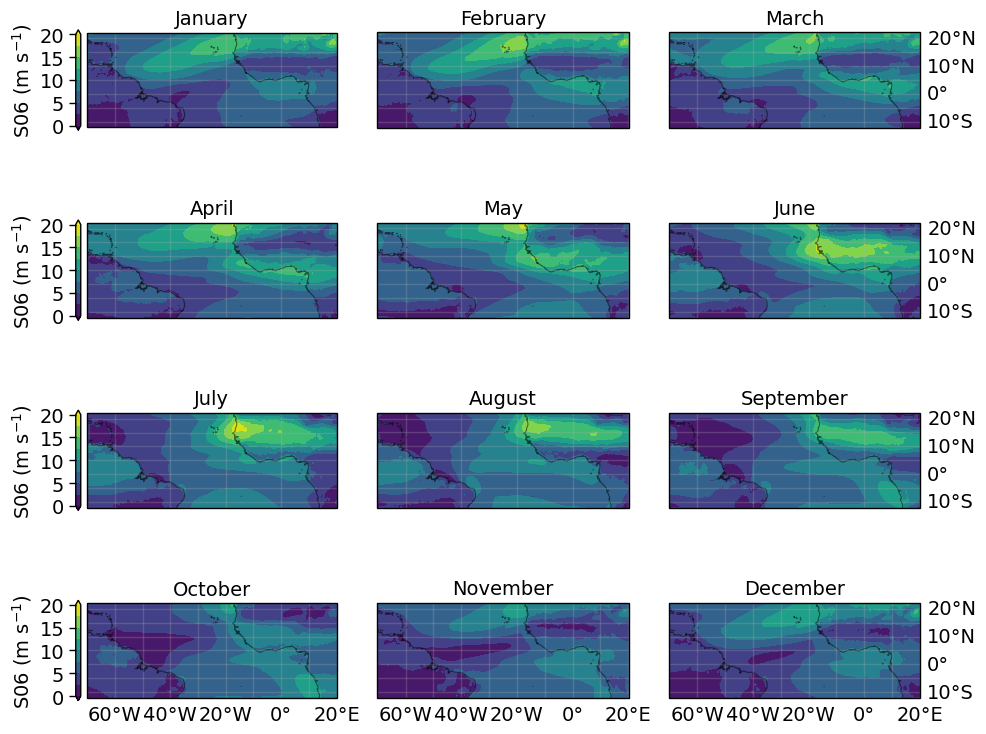

In [69]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_shear06_climo.sel(month=mm).longitude.values, 
                 era5_shear06_climo.sel(month=mm).latitude.values,
                 era5_shear06_climo.sel(month=mm).values,
                 cmap = 'viridis', levels=np.arange(0,22.5,2.5),extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('S06 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(0, 25, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(0, 25, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


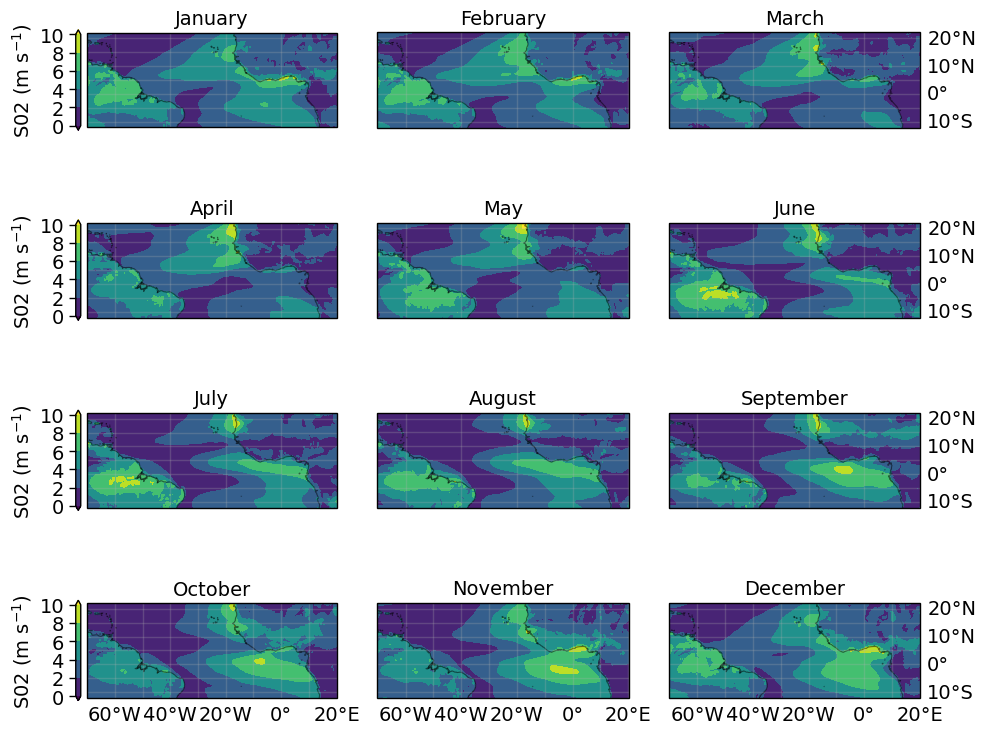

In [74]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_shear02_climo.sel(month=mm).longitude.values, 
                 era5_shear02_climo.sel(month=mm).latitude.values,
                 era5_shear02_climo.sel(month=mm).values,
                 cmap = 'viridis', levels=np.arange(0,12,2),extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('S02 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(0, 12, 2))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(0, 12, 2)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Plot low-level convergence (divergence...actually)

Processing month: 1
Processing month: 2


Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


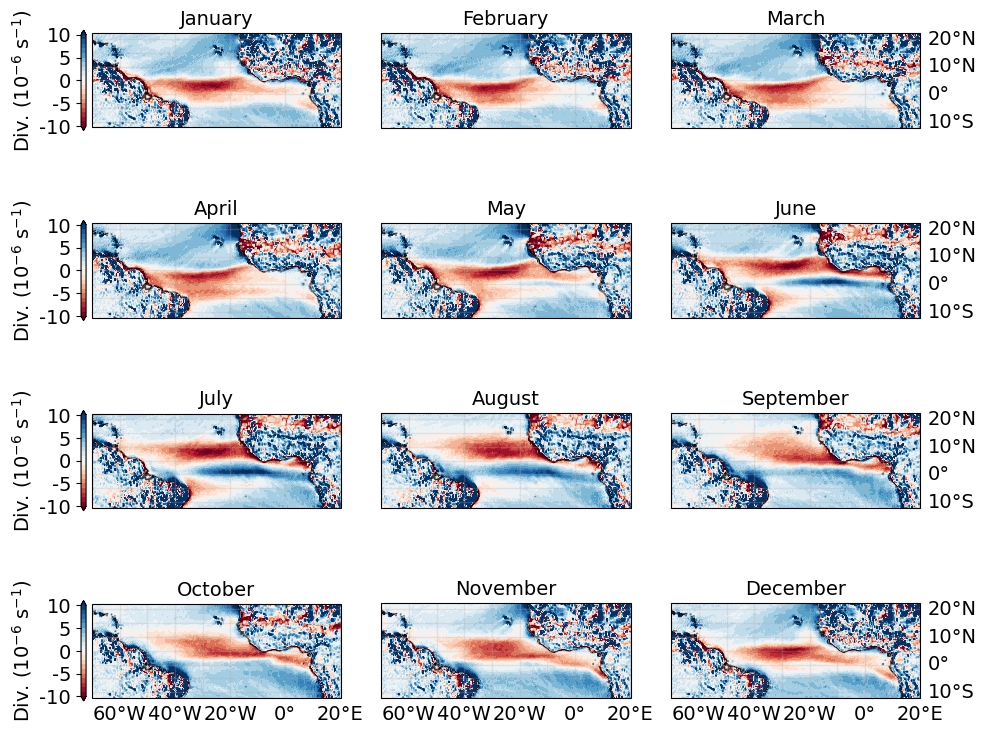

In [21]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_div1000_climo.sel(month=mm).longitude.values, 
                 era5_div1000_climo.sel(month=mm).latitude.values,
                 era5_div1000_climo.sel(month=mm).values*1e6,
                 cmap = 'RdBu',levels=np.arange(-10,11,1),extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('Div. (10$^{-6}$ s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-10,11,5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-10,11,5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Plot zonal winds

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


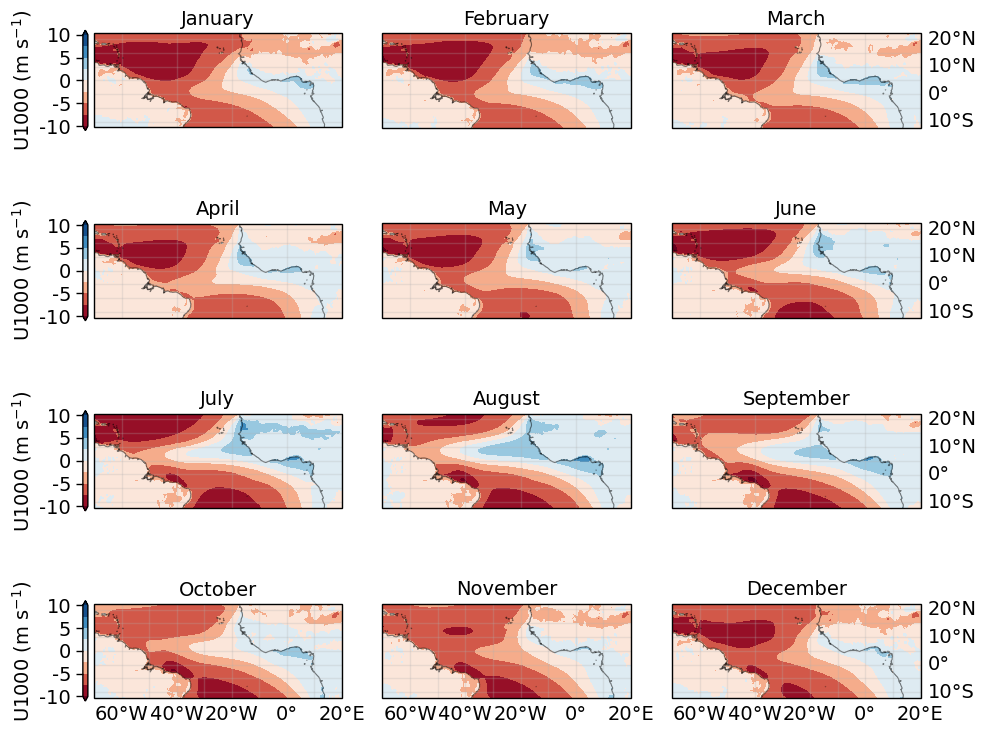

In [49]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.u.sel(month=mm, pressure_level=1000).values,
                 cmap = 'RdBu', levels = np.arange(-10,12.5,2.5), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('U1000 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-10, 15, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-10, 15, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


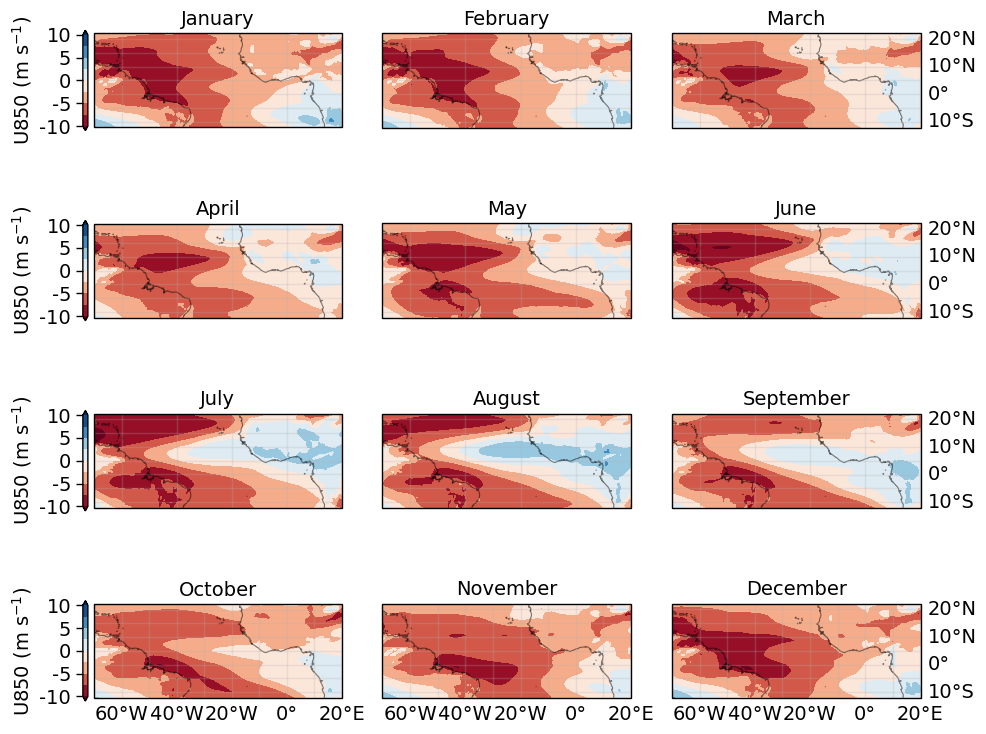

In [47]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.u.sel(month=mm, pressure_level=850).values,
                 cmap = 'RdBu', levels = np.arange(-10,12.5,2.5), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('U850 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-10, 15, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-10, 15, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


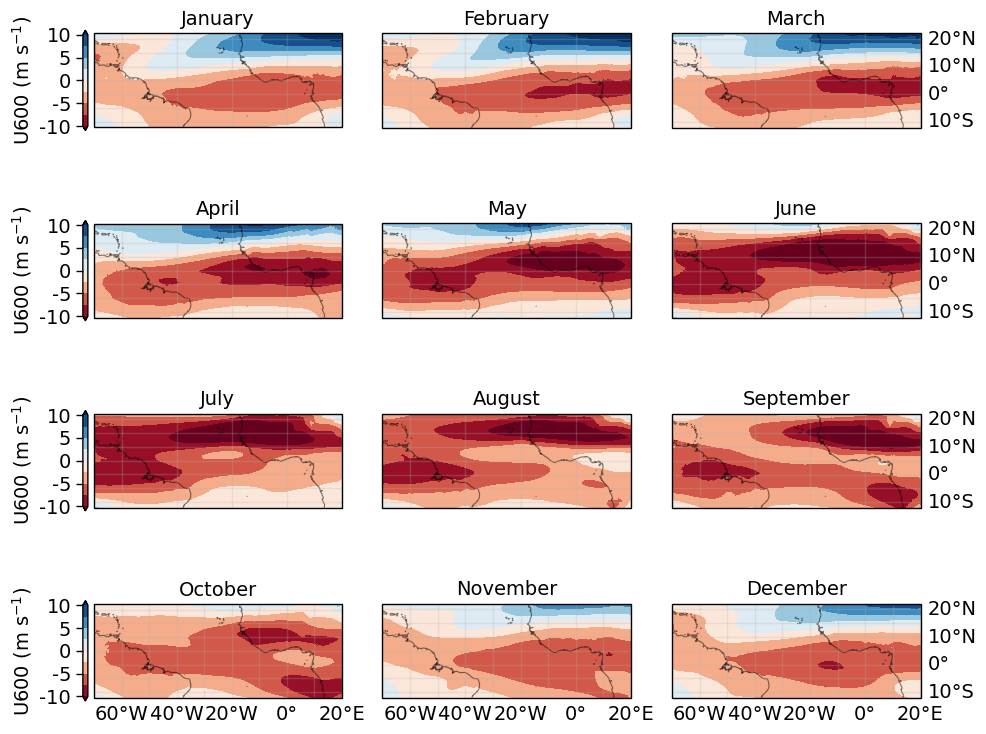

In [48]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.u.sel(month=mm, pressure_level=600).values,
                 cmap = 'RdBu', levels = np.arange(-10,12.5,2.5), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('U600 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-10, 15, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-10, 15, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

 Plot meridional winds

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


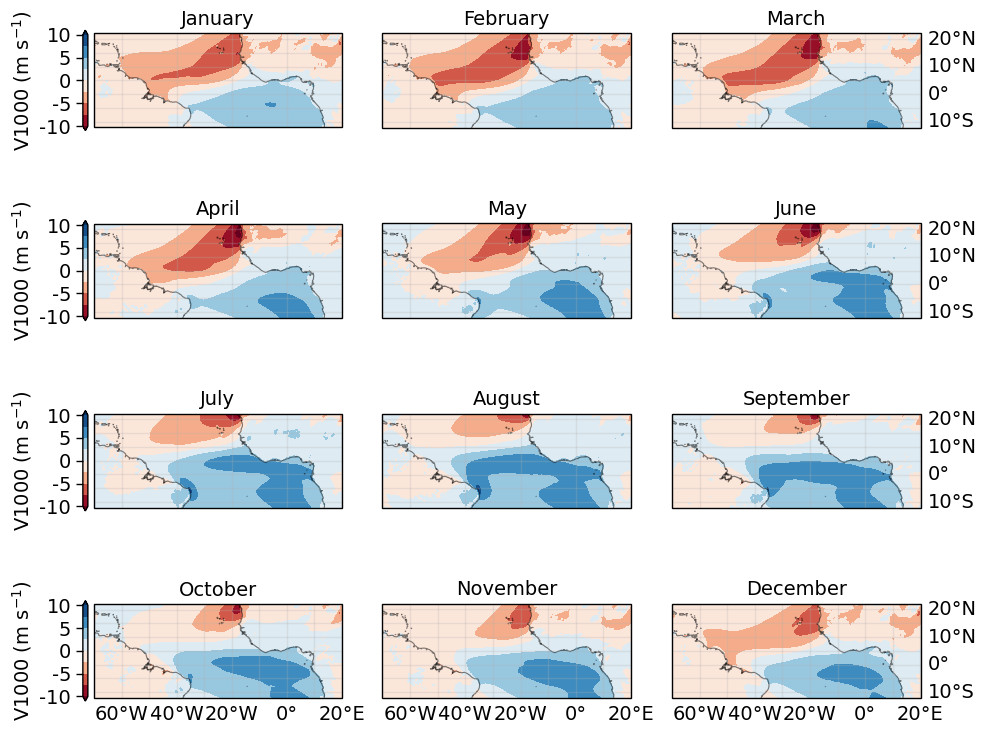

In [57]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.v.sel(month=mm, pressure_level=1000).values,
                 cmap = 'RdBu', levels = np.arange(-10,12.5,2.5), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('V1000 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-10, 15, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-10, 15, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2


Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


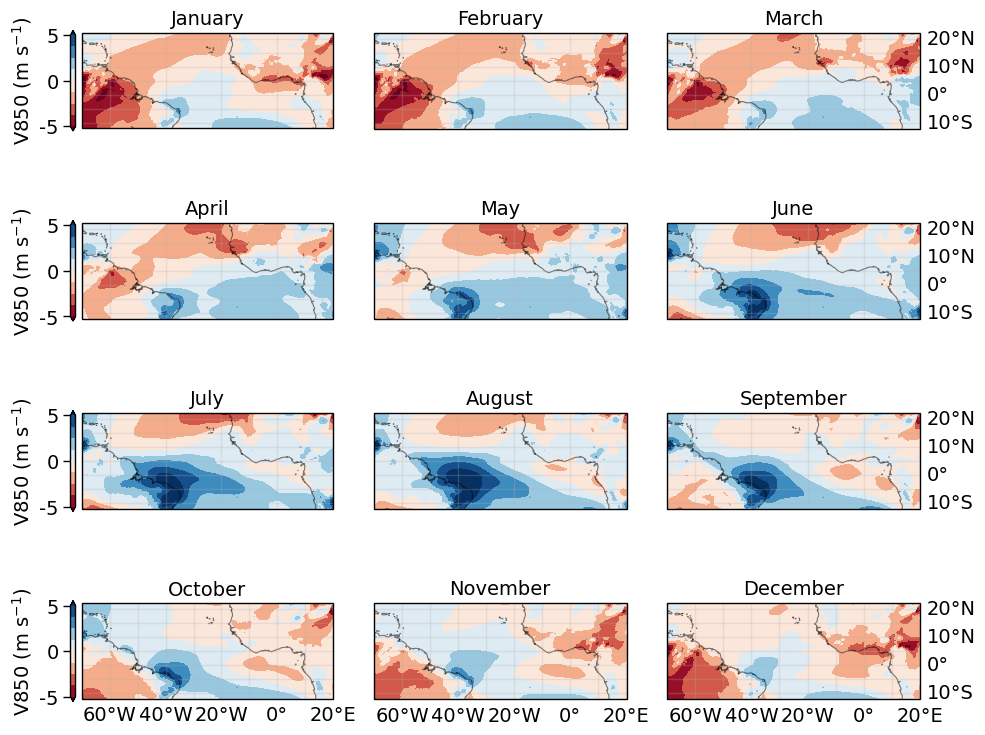

In [63]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.v.sel(month=mm, pressure_level=850).values,
                 cmap = 'RdBu', levels = np.arange(-5,6.25,1.25), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('V850 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-5, 10, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-5, 10, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


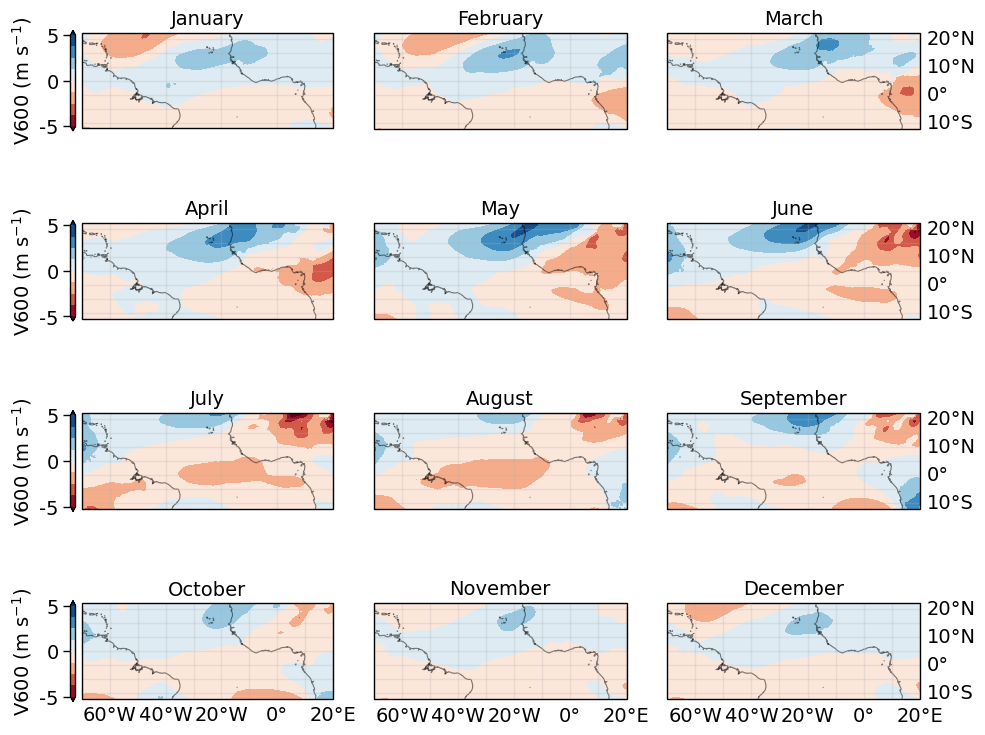

In [62]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_monthly_climo.sel(month=mm).longitude.values, 
                 era5_monthly_climo.sel(month=mm).latitude.values,
                 era5_monthly_climo.v.sel(month=mm, pressure_level=600).values,
                 cmap = 'RdBu', levels = np.arange(-5,6.25,1.25), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('V600 (m s$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(-5, 10, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-5, 10, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Plot other variables [vertically integrated potential + internal + latent energy, cwv, sst, vertically integrated moisture divergence]

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


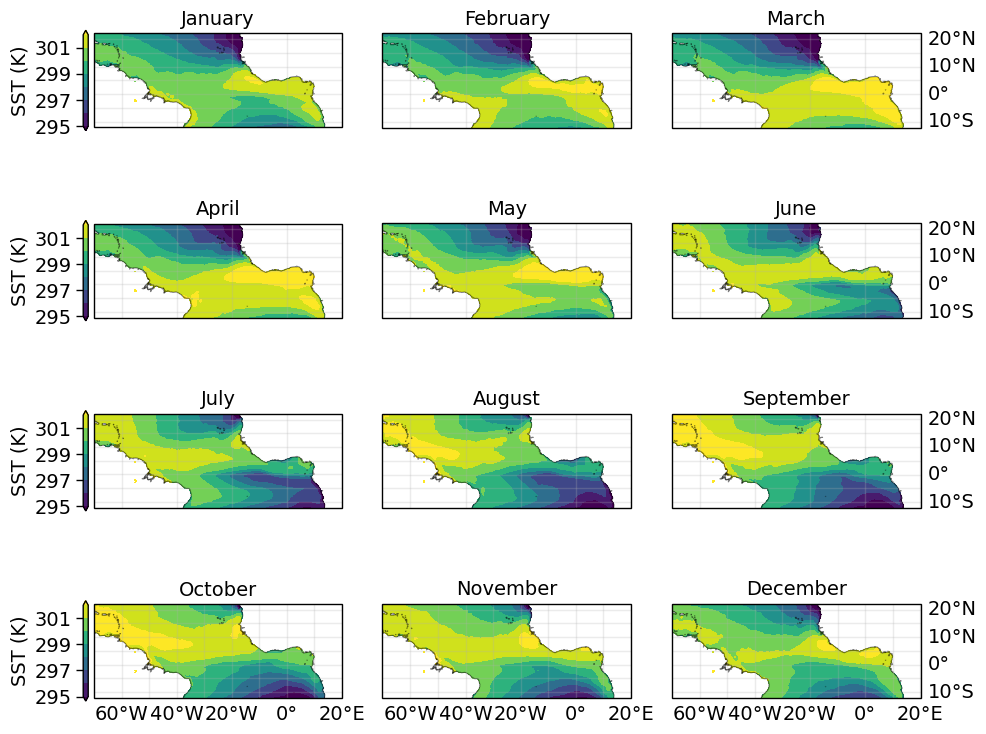

In [22]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_vipile_tcwv_sst_climo.sel(month=mm).longitude.values, 
                 era5_vipile_tcwv_sst_climo.sel(month=mm).latitude.values,
                 era5_vipile_tcwv_sst_climo.sst.sel(month=mm).values,
                 cmap = 'viridis',levels = np.arange(295,303,1), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('SST (K)',fontsize=14)
        cbar.set_ticks(np.arange(295, 303, 2))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(295, 303, 2)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


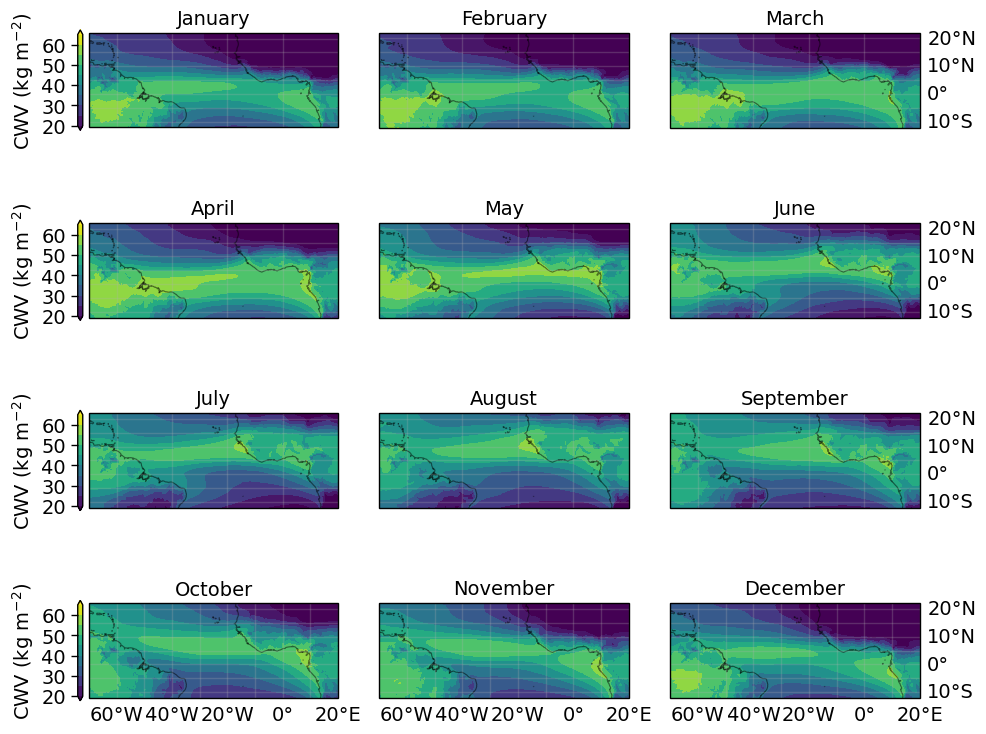

In [28]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_vipile_tcwv_sst_climo.sel(month=mm).longitude.values, 
                 era5_vipile_tcwv_sst_climo.sel(month=mm).latitude.values,
                 era5_vipile_tcwv_sst_climo.tcwv.sel(month=mm).values,
                 cmap = 'viridis',levels = np.arange(20,70,5), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('CWV (kg m$^{-2}$)',fontsize=14)
        cbar.set_ticks(np.arange(20, 70, 10))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(20, 70, 10)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


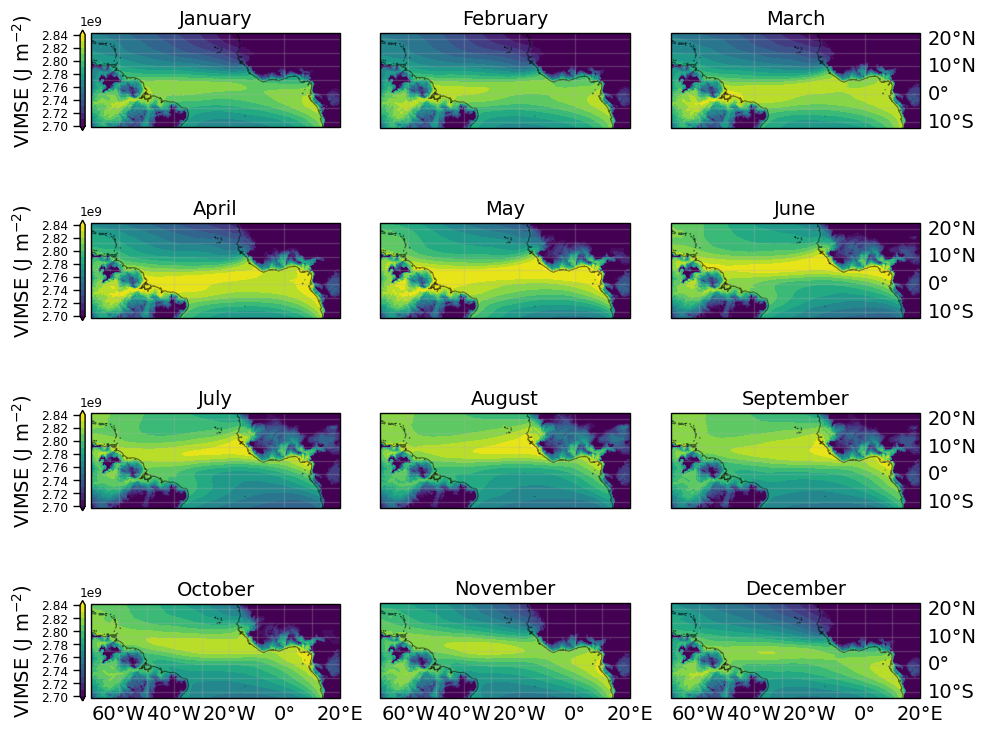

In [40]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_vipile_tcwv_sst_climo.sel(month=mm).longitude.values, 
                 era5_vipile_tcwv_sst_climo.sel(month=mm).latitude.values,
                 era5_vipile_tcwv_sst_climo.vipile.sel(month=mm).values,
                 cmap = 'viridis',levels = np.arange(2.7e9,2.85e9,0.01e9), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('VIMSE (J m$^{-2}$)',fontsize=14)
        #cbar.set_ticks(np.arange(-5, 10, 5))
        #cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-5, 10, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


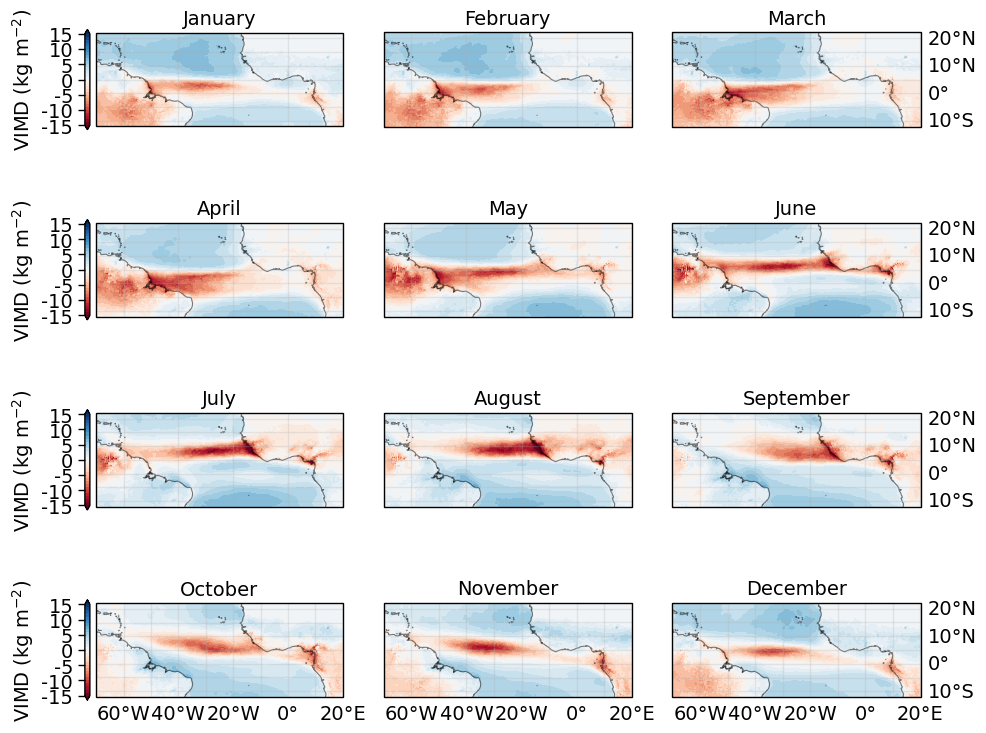

In [45]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
    
    # Plot  filled contours
    plt.contourf(era5_vimd_climo.sel(month=mm).longitude.values, 
                 era5_vimd_climo.sel(month=mm).latitude.values,
                 era5_vimd_climo.vimd.sel(month=mm).values,
                 cmap = 'RdBu',levels = np.arange(-15,16,1), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('VIMD (kg m$^{-2}$)',fontsize=14)
        cbar.set_ticks(np.arange(-15, 16, 5))
        cbar.set_ticklabels([f'{x:.0f}' for x in np.arange(-15, 16, 5)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.

Processing month: 1
Processing month: 2
Processing month: 3
2
Processing month: 4
Processing month: 5
Processing month: 6
5
Processing month: 7
Processing month: 8
Processing month: 9
8
Processing month: 10
9
Processing month: 11
10
Processing month: 12
11
11


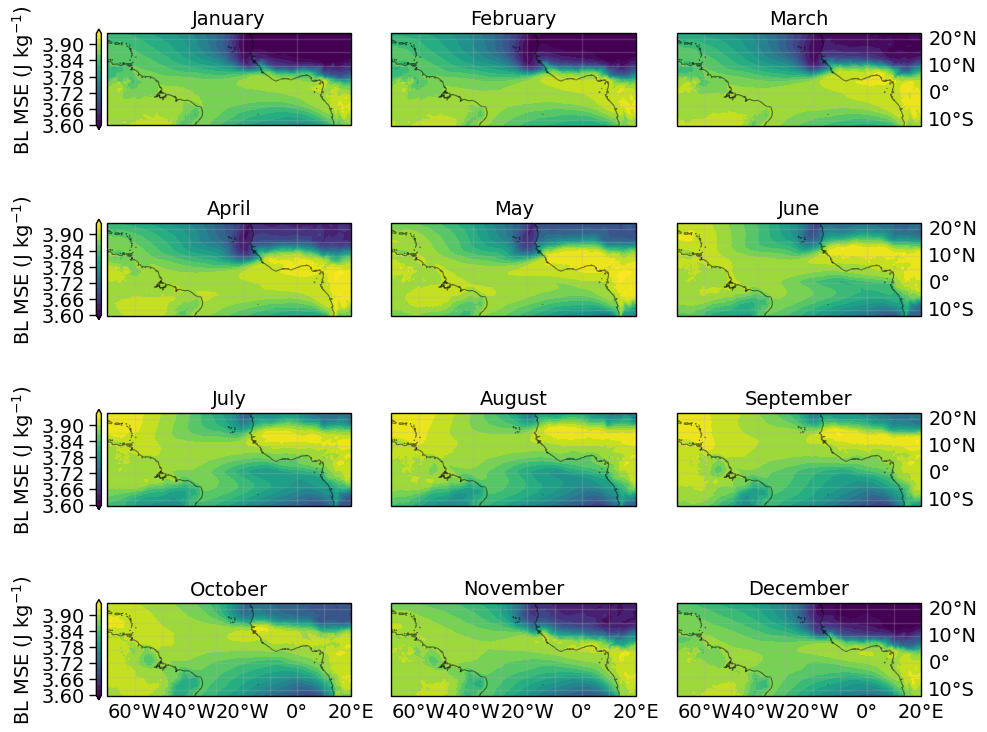

In [63]:
# For each month, spatial plot

fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(4, 3, width_ratios=[1.2, 1, 1])

months = np.arange(1,13)  # 1-12
imonth = 0
for mm in months:
    # print month
    print("Processing month:", mm)
       
    # Create plot
    ax1 = fig.add_subplot(gs[imonth],projection=ccrs.PlateCarree())
    ax1.coastlines(resolution = '50m',alpha=0.5)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
    gl.top_labels = False
    gl.left_labels = False
    if imonth==9 or imonth==10 or imonth==11:
        print(imonth)    
        gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10, 20])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 14}
    else: 
        gl.bottom_labels = False
    if imonth==2 or imonth==5 or imonth==8 or imonth==11:
        print(imonth)
        gl.ylocator = mticker.FixedLocator([-10, -5,0, 5, 10, 15, 20])
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size': 14}
    else:
        gl.right_labels = False
        
    blmse = 1004*era5_tqzd_climo.t.sel(month=mm, pressure_level=950) + 9.8*era5_tqzd_climo.z.sel(month=mm, pressure_level=950) + 2.5e6*era5_tqzd_climo.q.sel(month=mm, pressure_level=950)
    
    # Plot  filled contours
    plt.contourf(era5_tqzd_climo.sel(month=mm).longitude.values, 
                 era5_tqzd_climo.sel(month=mm).latitude.values,
                 blmse.values/1e5,
                 cmap = 'viridis',levels = np.arange(3.6,3.95,0.02), extend='both')
    
    if imonth==0 or imonth==3 or imonth==6 or imonth==9:
        cbar=plt.colorbar(location='left',orientation='vertical',shrink = 0.5, pad=0.02)
        cbar.set_label('BL MSE (J kg$^{-1}$)',fontsize=14)
        cbar.set_ticks(np.arange(3.6, 3.95, 0.06))
        cbar.set_ticklabels([f'{x:.2f}' for x in np.arange(3.6, 3.95, 0.06)],fontsize=14)

    # Set the plot limits and title
    if mm == 1:
        ax1.set_title('January',size=14)
    elif mm == 2:
        ax1.set_title('February',size=14)
    elif mm == 3:
        ax1.set_title('March',size=14)
    elif mm == 4:
        ax1.set_title('April',size=14)
    elif mm == 5:   
        ax1.set_title('May',size=14)
    elif mm == 6:
        ax1.set_title('June',size=14)
    elif mm == 7:
        ax1.set_title('July',size=14)
    elif mm == 8:
        ax1.set_title('August',size=14)
    elif mm == 9:   
        ax1.set_title('September',size=14)
    elif mm == 10:
        ax1.set_title('October',size=14)
    elif mm == 11:
        ax1.set_title('November',size=14)
    else:
        ax1.set_title('December',size=14)
        
    ax1.set_xlim(lonMin, lonMax)
    ax1.set_ylim(latMin, latMax)
    
    imonth=imonth+1
    
sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.